1. Read the dataset, visualize it

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import collections

In [2]:
news = pd.read_excel("Yandex_news.xlsx")

In [3]:
data = news["plotline"]
counter=collections.Counter(data)
df = pd.DataFrame.from_dict(counter, orient='index')
df

,0
Байден обвинил Трампа в провоцировании беспорядков в Вашингтоне,10
Facebook заблокировал аккаунт Трампа до конца его президентского срока,10
Стрелявший у Капитолия США полицейский отстранен от службы,3
Советник Трампа по России Тулли подал в отставку из-за акций протеста в Вашингтоне,4
Лидеры стран Латинской Америки осудили насилие в Конгрессе США,5
Меркель отреагировала на события в Вашингтоне,6
В результате беспорядков у Капитолия в Вашингтоне погибли четыре человека,8
Нэнси Пелоси призвала использовать против Трампа 25-ю поправку к Конституции США,10
Горбачев увидел угрозу будущему США после беспорядков в Вашингтоне,10
Конгресс США утвердил победу Джозефа Байдена на выборах президента,10


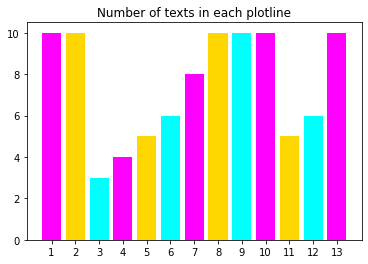

<Figure size 432x288 with 0 Axes>

In [4]:
#distribution of news by plotlines
fig, ax = plt.subplots()
plt.bar(counter.keys(), counter.values(), tick_label = list(range(1, len(counter.values())+1)), color = ["fuchsia","gold", "aqua"])
ax.set_title('Number of texts in each plotline')
plt.show()
plt.savefig('CP_g1.png')

In [5]:
news.head(2)

,link,text,plotline
0,https://riafan.ru/1365542-baiden-obvinil-tramp...,"Вашингтон, 7 января. Избранный глава государст...",Байден обвинил Трампа в провоцировании беспоря...
1,https://russian.rt.com/world/news/820328-baide...,Избранный президент США Джо Байден назвал собы...,Байден обвинил Трампа в провоцировании беспоря...


2. Preprocess texts: lower case, tokenization and lemmatization, removing stopwords and punctuation

In [6]:
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

In [7]:
mystem = Mystem()

In [8]:
stopwords_rus = stopwords.words("russian") + ["сообщить", "сообщать", "передавать", "передать", "заявить", "объявить", "тасс", "риа", "CNN", "новость", "известия", "это", "fox", "несколько" "следующий", "сказать", "говорить", "uscp", "the"]
exclude = punctuation + '–—'+'«»'+'…\/“”№£][)(!-_.,'+" "+'``' + '`' + '’' + "..." + '-PRON-' + "&"+ "», — " + ", «" + "«" + "»" + "», "

In [9]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stopwords_rus\
              and token != " " \
              and token.strip() not in exclude \
              and token.strip(" ") not in exclude \
              and "\"" not in token
              and "," not in token]
    return tokens

In [10]:
news["nltk_tokenized"] = ""

In [11]:
start = time.time()
for index, row in news.iterrows():
    news.iloc[index, 3] = preprocess_text(news.iloc[index,1])
print("Preprocessing texts with NLTK took {} seconds".format(time.time()-start))

Preprocessing texts with NLTK took 7.638293504714966 seconds


In [12]:
news.head(2)

,link,text,plotline,nltk_tokenized
0,https://riafan.ru/1365542-baiden-obvinil-tramp...,"Вашингтон, 7 января. Избранный глава государст...",Байден обвинил Трампа в провоцировании беспоря...,"[вашингтон, 7, январь, избранный, глава, госуд..."
1,https://russian.rt.com/world/news/820328-baide...,Избранный президент США Джо Байден назвал собы...,Байден обвинил Трампа в провоцировании беспоря...,"[избранный, президент, сша, джо, байден, назыв..."


3. Apply LSH

In [13]:
from snapy import MinHash, LSH

In [14]:
#convert preprocessed texts back to string
texts_tokenized = []
for el in news["nltk_tokenized"]:
    el_str = " ".join(el)
    texts_tokenized.append(el_str)

In [15]:
#example
texts_tokenized[29:31]

['российский телеведущий владимир соловьев обращать внимание комментарий президент украина владимир зеленский который украинский лидер заявлять решительно осуждать событие вашингтон ранее зеленский написать свой twitter аккаунт отношение киев событие происходить сша решительно осуждать беспрецедентный насилие против конгресс сша вдохновлять стойкость старый великий демократический институт мир который несколько час ужасный нападение проводить исторический заседание подтвердить воля американский народ подчеркивать зеленский все-таки против майдан задаваться вопрос соловьев свой telegram канал накануне конгресс сша должный утверждать результат президентский выборы однако заседание внезапно прерывать из-за сторонник действующий президент дональд трамп ворваться здание капитолий устраивать беспорядок правоохранительный орган вынуждать применять слезоточивый газ светошумовой граната невыясненный обстоятельство огнестрельный ранение правительственный комплекс погибать ветеран ввс эшли бэббит

In [16]:
#labels are needed for the LSH model
#set counting numbers as labels
labels = list(range(1, len(news)+1))
seed = 666

In [17]:
#train the model
#shingle into bigrams
#number of matrix permutation = 200
#hash value size = 64
#number of buckets = 100
#bucket size = 2
start = time.time()
minhash = MinHash(texts_tokenized, n_gram=2, n_gram_type='term', permutations=200, hash_bits=64, seed=seed) #create signatures
lsh = LSH(minhash, labels, no_of_bands=100)

print("Training LSH model took {} seconds".format(time.time()-start))

Training LSH model took 1.9319016933441162 seconds


In [18]:
#example of query
lsh.query(69)

[72, 75, 43, 70, 74]

4. Visualize the results

In [19]:
#create edge list based on the Jaccard similarity
edge_list = lsh.edge_list(jaccard_weighted=True, sensitivity=1)

In [20]:
#!pip install networkx

In [21]:
import networkx as nx

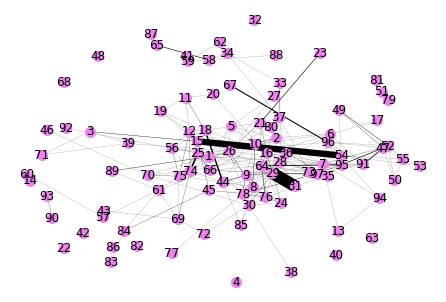

In [22]:
g = nx.Graph()
g.add_nodes_from(list(range(1, 98)))

all_weights = []
for edge in edge_list:
    g.add_edge(edge[0], edge[1], weight = edge[2])
    all_weights.append(edge[2]*12)
nx.draw(g, node_size = 100, node_color = "violet", width=all_weights, with_labels=True)

5. Add new text to the model

In [23]:
#let's parse it from a given url
import requests
from bs4 import BeautifulSoup

In [24]:
url = "https://ria.ru/20210110/pence-1592433391.html"

In [25]:
def get_html(url):
    r = requests.get(url)
    return r.text

In [26]:
data = get_html(url)
soup = BeautifulSoup(data, features='lxml')
s = ""
for el in soup.find_all("div", {"itemprop" : "articleBody"}):
    text_part = el.get_text()
    s = s +" " +text_part

In [27]:
new_txt = " ".join(preprocess_text(s))
new_label = [labels[-1] + 1] #lables can't be added in integer or float format, only as list or array

In [28]:
new_txt

'москва 10 янва вице-президент сша майк пенс посещать инаугурация джо байден 20 январь телеканал nbc ссылка источник знакомый решение вице-президент байден ранее приглашать вице-президент сша пенс свой инаугурация байден заявлять журналист решение президент дональд трамп посещать инаугурация ранее трамп заявлять пойти инаугурация представитель пенс заявлять вице-президент туда приглашать инаугурация байден пройти 20 январь'

In [29]:
minhash_upd = MinHash(new_txt, n_gram=2, n_gram_type='term', permutations=200, hash_bits=64, seed=seed)
lsh.update(minhash_upd, new_label)

In [30]:
lsh.query(98)

[3, 15]

Finding potential reprints

In [31]:
#in order to find potential reprints, it is necessary to restrict conditions of putting texts into the same bucket
#increase shingle size and number of signs in a bucket (4 insted of 2)
start = time.time()
minhash_new = MinHash(texts_tokenized, n_gram=5, n_gram_type='term', permutations=200, hash_bits=64, seed=seed) #create signatures
lsh_new = LSH(minhash, labels, no_of_bands=50)

print("Training new LSH model took {} seconds".format(time.time()-start))

Training new LSH model took 1.4057817459106445 seconds


In [32]:
lsh_new.edge_list()

[(75, 74), (65, 58), (52, 47), (10, 2)]

In [33]:
example_repr = lsh_new.edge_list()[-1]

In [34]:
print(texts_tokenized[example_repr[0]-1])
print()
print(texts_tokenized[example_repr[1]-1])

избранный американский президент джозеф байден называть событие капитолий хаос участник штурм внутренний террорист мятежник демократ уверенный вчерашний беспорядок вашингтон спровоцировать дональд трамп проигрывать президентский выборы байден заявлять четверг 7 январь выступать речь сторонник протест беспорядок настоящий хаос мочь называть участник протестовать мятежник чернь внутренний террорист результат безжалостный нападки президент трамп демократия хотеть мочь ожидать мочь отмечать новый глава сша байден заявлять трамп нападать свободный пресса называть журналист враг народ также совершать нападки разведслужба военнослужащий использовать лексика который пользоваться автократ диктатор свой очередь спикер палата представитель нэнси пелось призывать немедленно отстранять трамп власть соответствие 25 й поправка конституция писать сайт kp ru вчера протестовать сторонник трамп устраивать беспорядок вашингтон штурм захватить здание капитолий полиция спецназ смочь разгонять демонстрант ре

In [35]:
print(texts_tokenized[51])
print()
print(texts_tokenized[46])

спикер палата представитель сша нэнси пелось лидер демократ сенат чак шумер предлагать вице-президент майка пенс воспользоваться 25 й поправка конституция сша отстранять действующий президент дональд трамп должность сей пора получать ответ демократ рассчитывать господин пенс озвучивать свой решение близкий время сегодня утро обращаться вице-президент пенс призыв применять 25 ю поправка который позволять вице-президент большинство член кабинет отстранять президент должность подстрекательство мятеж из-за опасность который весь представлять получать ответ вице-президент ожидать услышать ответ вице-президент скоро говориться заявление демократ который приводить hill применение поправка помимо нэнси пелось чак шумер ранее выступать ряд конгрессмен оба партия 25 поправка конституция сша позволять вице-президент сша полномочие президент случай недееспособность глава государство газета new york times утверждать вице-президент сша майк пенс выступать против отстранение дональд трамп должность п